In [59]:
library(ggplot2)
library(stringr)
# Please read the offical documentation of SparkR to learn more about the possibilities
# to load data files: https://spark.apache.org/docs/2.0.1/api/R/
# The SparkSession object is already initalized for you.
# The following variable contains the path to your file on your Object Storage.
path <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "1988.csv.bz2", sep="")
#path.2 <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "1996.csv.bz2", sep="")
#path.3 <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "2001.csv.bz2", sep="")
#path.4 <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "2004.csv.bz2", sep="")
#path.5 <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "2007.csv.bz2", sep="")
#path.6 <- paste("swift://", "DefaultProjectserpenaalumniuves", "." , name,"/", "2008.csv.bz2", sep="")
prepareDF <- function(df) {
    # Get column names from first row
    namesDF <- take(df,1)
    # Check if already processed and return
    if (namesDF[1] != "Year") return(df)
    names(df) <- namesDF
    # Remove (filter) first row
    df <- filter(df, df$Year != "Year")
    # All columns are read as string => set right types
    coltypes(df) <- c(rep('integer',8), 'character', 'integer', 'character', rep('integer',5),
             rep('character',2), rep('integer', 4), 'character', rep('integer',6))
    return(df)
}

df <- read.df(path, 'csv')
df <- prepareDF(df)
tb <- df
    
for(an in c(1992,1998,2001,2002,2004,2008))
    {
    path2 <- str_replace(path, '1988', an)
    df <- read.df(path2, 'csv')
    df <- prepareDF(df)
    tb <- rbind(tb,df)
}

df_planes <- read.df(str_replace(path, '1988.csv.bz2', "plane-data.csv"), 'csv')
names(df_planes) <- take(df_planes,1)
names(df_planes) <- paste0("P_",names(df_planes))
df_planes <- filter(df_planes, df_planes$P_tailnum != "P_tailnum")
df_planes <- na.omit(df_planes)
    
tb <- join(tb, df_planes, tb$TailNum == df_planes$P_tailnum) #Juntamos numero de cola

In [67]:
#When is the best time of day/day of week/time of year to fly to minimise delays?
head(summarize(groupBy(df, df$DayofMonth), count = n(df$ArrDelay)))

DayofMonth,count
31,97174
28,170059
26,168050
27,169255
12,169159
22,171589


In [2]:
df_group_YearMonth <- collect(summarize(groupBy(tb,tb$DayofMonth, tb$Year), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay)))
df_group_YearWeek <- collect(summarize(groupBy(tb,tb$DayOfWeek, tb$Year), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay)))
df_group_Year <- collect(summarize(groupBy(tb,tb$Year), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay)))
df_group_YearCarrier <- collect(summarize(groupBy(tb,tb$Year, tb$UniqueCarrier), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay)))

# When is the best time of day/day of week/time of year to fly to minimise delays?

In [3]:
head(df_group_YearMonth)

DayofMonth,Year,count,depdelay,arrdelay
1,2004,233690,9.482026,8.079145
16,1998,179837,10.226207,9.596844
20,2001,197520,7.946189,5.180681
28,2001,193325,6.878945,3.919359
21,1998,176085,8.663326,7.341690
9,2002,172012,4.346498,1.710663


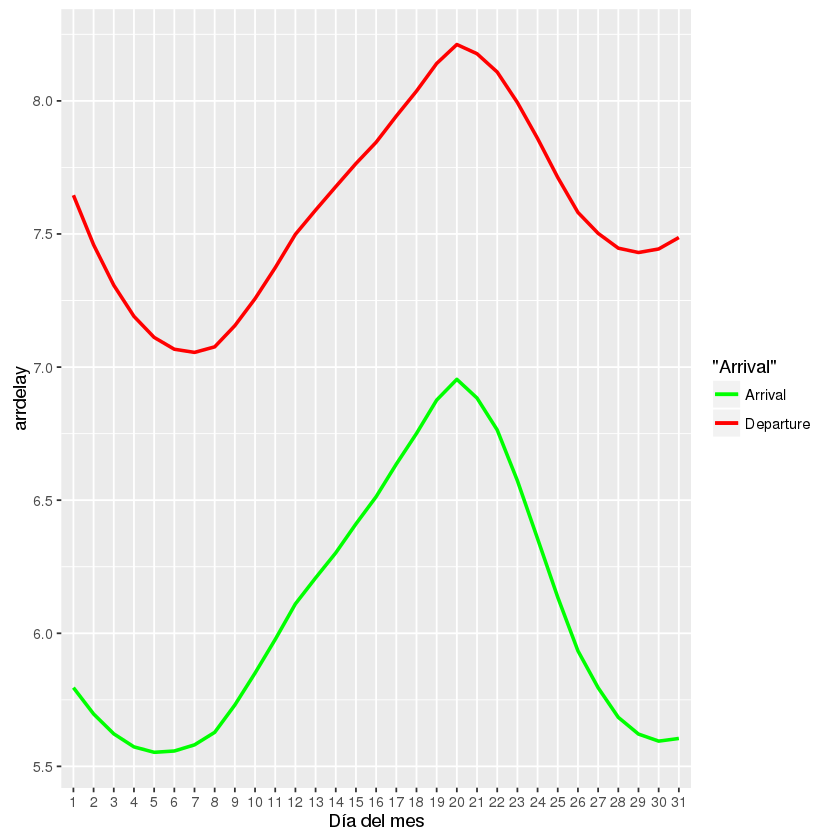

In [6]:
var_span = 0.5
ggplot(df_group_YearMonth, aes(x=DayofMonth)) + geom_smooth( aes(y=arrdelay, color="Arrival"),method="auto", span=var_span, se =F) + 
geom_smooth( aes(y=depdelay, color="Departure"),method="auto", span=var_span, se=F) + scale_colour_manual(values = c("green","red")) + scale_x_discrete(name ="Día del mes", limits=seq(31))

Vemos claramente como en los días 6-8 y 25-27 suelen ser generalmente los días con menos retraso. Podemos confirmar esto mediante boxplots por día.

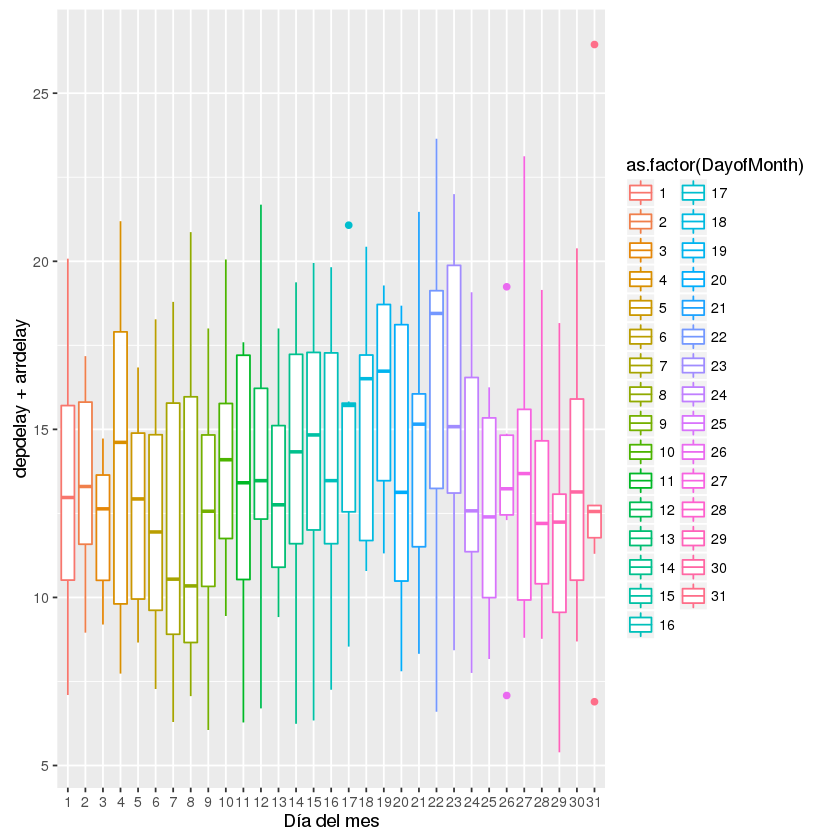

In [7]:
ggplot(df_group_YearMonth, aes(x=DayofMonth, y=depdelay+arrdelay)) + geom_boxplot(aes(color=as.factor(DayofMonth))) + scale_x_discrete(name ="Día del mes", limits=seq(31))

In [27]:
head(df_group_YearWeek)

DayOfWeek,Year,count,depdelay,arrdelay
1,2004,1044508,8.984523,7.797879
3,2004,1036521,7.442615,6.823174
6,1998,694528,7.170546,3.567345
4,1998,796404,10.114905,9.597676
3,1992,758213,5.621659,5.422945
2,2002,780556,4.517300,2.537213


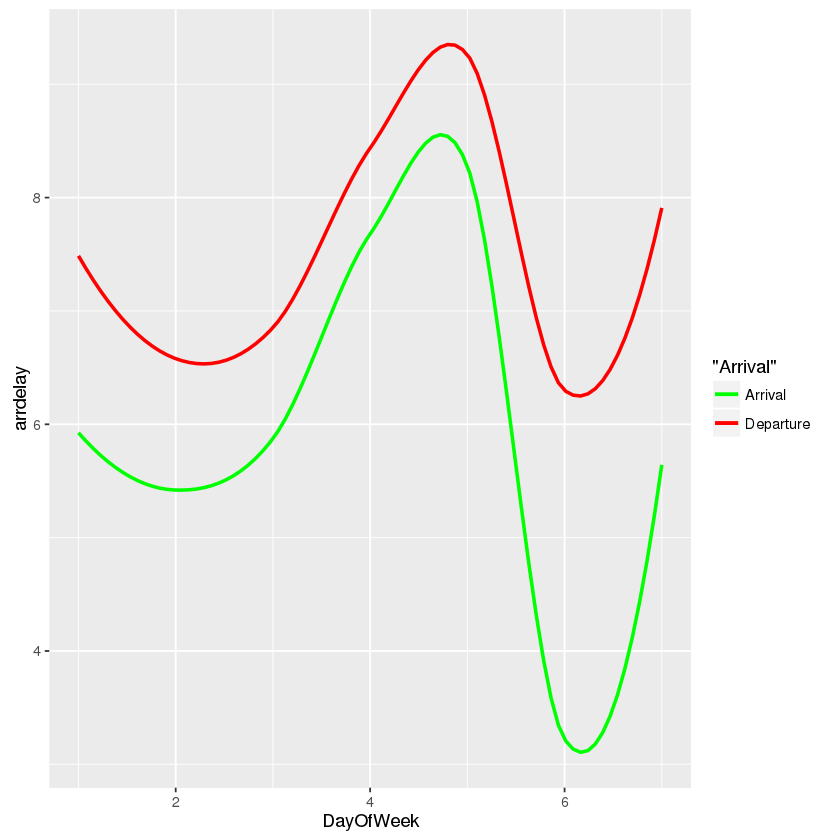

In [55]:
#ggplot(df_group, aes(x=DayOfWeek, y=depdelay+arrdelay)) + geom_smooth(method="auto", span=0.5)
var_span = 0.5
ggplot(df_group_YearWeek, aes(x=DayOfWeek)) + geom_smooth( aes(y=arrdelay, color="Arrival"),method="auto", span=var_span, se =F) + 
geom_smooth( aes(y=depdelay, color="Departure"),method="auto", span=var_span, se=F) + scale_colour_manual(values = c("green","red")) 


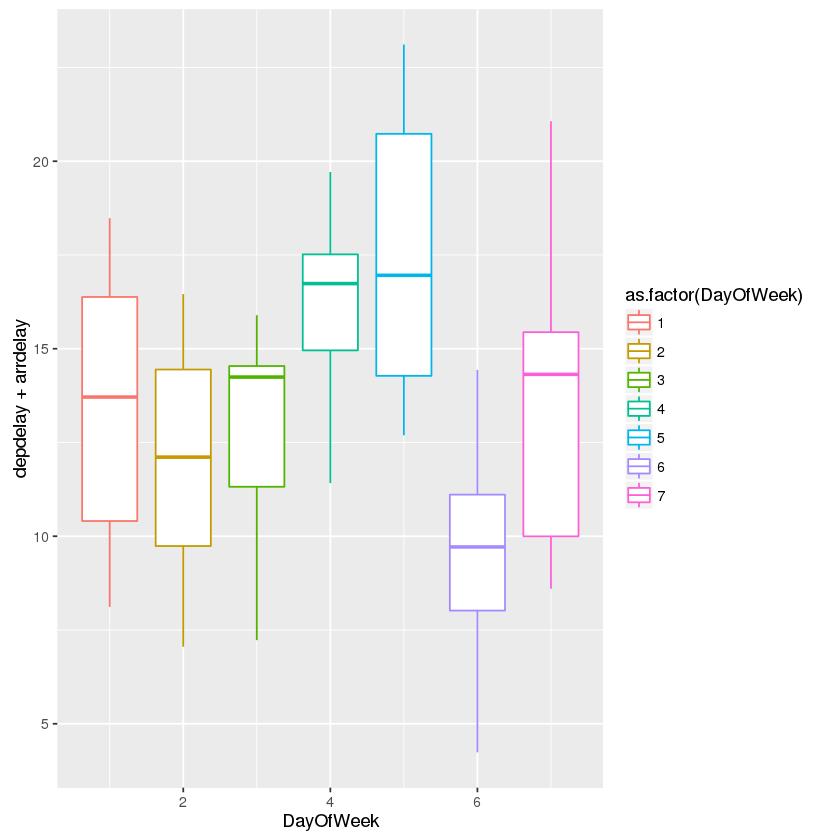

In [56]:
ggplot(df_group_YearWeek, aes(x=DayOfWeek, y=depdelay+arrdelay)) + geom_boxplot(aes(color=as.factor(DayOfWeek)))

Podemos observar rápidamente como el día 6 es el claro día con menor retraso

# Do older planes suffer more delays?

In [71]:
df_group <- collect(summarize(groupBy(tb,tb$Year), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay), age = mean(tb$Year - tb$P_year)))
head(df_group)


Year,count,depdelay,arrdelay,age
2004,4531842,7.546522,6.430154,10.470682
1998,1846587,8.824315,7.345903,9.363446
2001,252809,4.870521,2.431193,5.992702
2008,6199619,9.931374,8.106591,12.249601
2002,2023619,4.748326,3.044601,10.153560


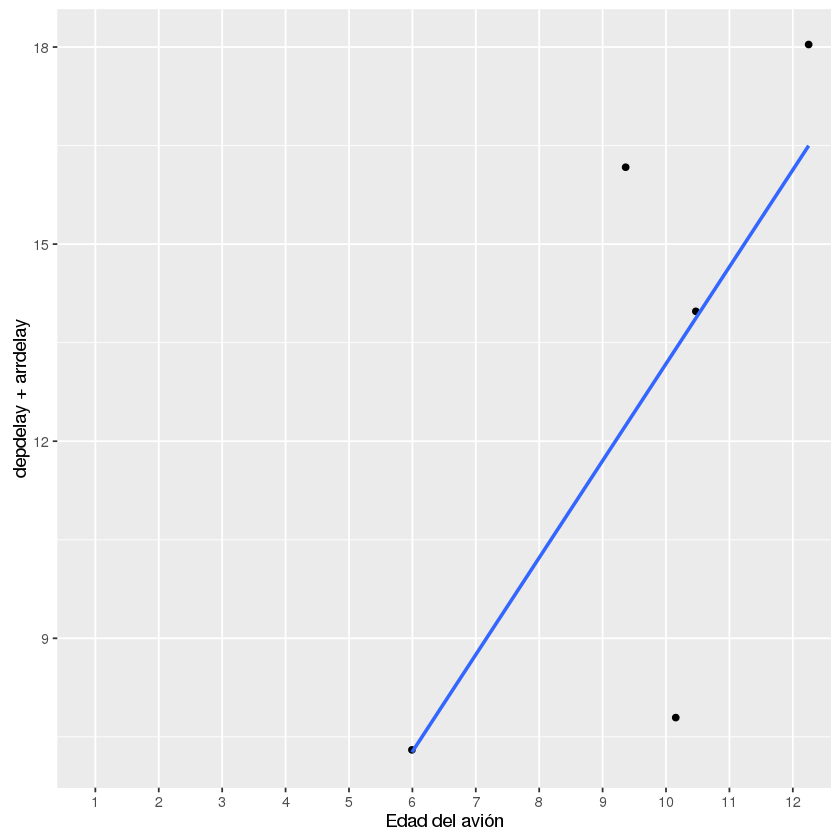

In [86]:
ggplot(df_group, aes(x=age, y=depdelay + arrdelay)) + geom_point()  + geom_smooth(method = "lm", se=F) + scale_x_discrete(name ="Edad del avión", limits=seq(max(df_group$age)))

Es evidente que sí, cuanto mas viejo es el avión mayores son los retrasos.

# How does the number of people flying between different locations change over time?

In [93]:
df_group_YearCarrier <- collect(summarize(groupBy(tb,tb$Year), count = n(tb$Year)))
head(df_group)

Year,count,depdelay,arrdelay,age
2004,4531842,7.546522,6.430154,10.470682
1998,1846587,8.824315,7.345903,9.363446
2001,252809,4.870521,2.431193,5.992702
2008,6199619,9.931374,8.106591,12.249601
2002,2023619,4.748326,3.044601,10.153560


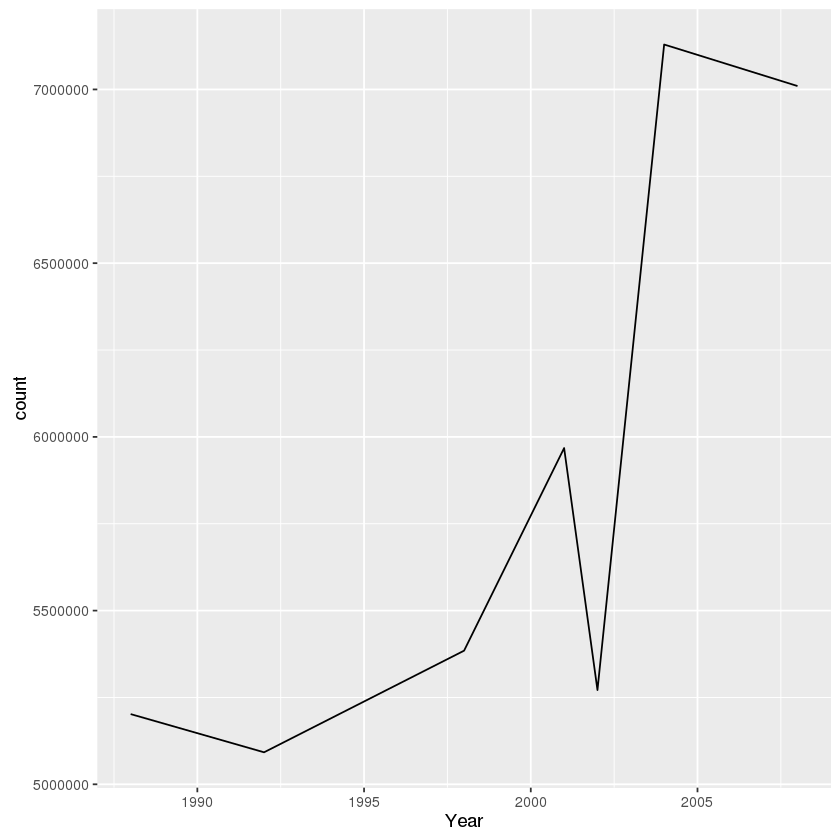

In [91]:
ggplot(df_group_Year, aes(x = Year, y = count)) + geom_line()

In [ ]:
ggplot(df_group, aes(x=Year, y=count)) + geom_line(aes(color=UniqueCarrier), size=0.5) + geom_point(aes(color=UniqueCarrier))

# How well does weather predict plane delays?

In [98]:
df_group <- collect(summarize(groupBy(filter(tb, tb$WeatherDelay > 0),tb$DayofMonth), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay), wd = mean(tb$WeatherDelay)))

Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”

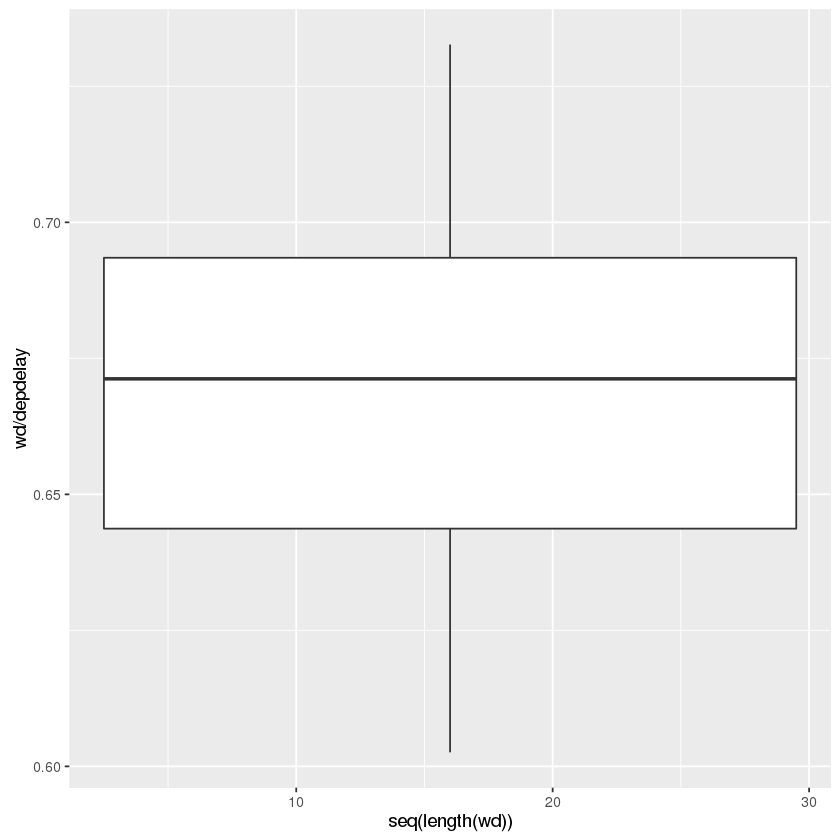

In [109]:
#ggplot(df_group, aes(x = seq(length(wd)), y=wd/depdelay)) + geom_point()  + geom_abline(intercept = mean(df_group$wd/df_group$depdelay, na.rm = T), slope = 0, color="red")
ggplot(df_group, aes(x = seq(length(wd)), y=wd/depdelay)) + geom_boxplot() 
#ggplot(df_group, aes(x = seq(length(wd)), y=wd/arrdelay)) + geom_point()  + geom_abline(intercept = mean(df_group$wd/df_group$depdelay, na.rm = T), slope = 0, color="red")
ggplot(df_group, aes(x = seq(length(wd)), y=wd/arrdelay)) + geom_boxplot() 

In [ ]:
df_group <- collect(summarize(groupBy(filter(tb, tb$WeatherDelay > 0),tb$UniqueCarrier), count = n(tb$Year), depdelay = mean(tb$DepDelay), arrdelay = mean(tb$ArrDelay), wd = mean(tb$WeatherDelay)))

In [ ]:
#ggplot(df_group, aes(x = seq(length(wd)), y=wd/depdelay)) + geom_point()  + geom_abline(intercept = mean(df_group$wd/df_group$depdelay, na.rm = T), slope = 0, color="red")
ggplot(df_group, aes(x = seq(length(wd)), y=wd/depdelay)) + geom_boxplot() 
#ggplot(df_group, aes(x = seq(length(wd)), y=wd/arrdelay)) + geom_point()  + geom_abline(intercept = mean(df_group$wd/df_group$depdelay, na.rm = T), slope = 0, color="red")
ggplot(df_group, aes(x = seq(length(wd)), y=wd/arrdelay)) + geom_boxplot() 